In [1]:
pip install facenet_pytorch

     |████████████████████████████████| 1.9MB 7.8MB/s 


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import torch
import torchvision
from torchvision import transforms
from skimage import io, transform
from torch import nn

import json

import numpy as np

from losses import *
from train import *
from plots import *
from gan import *
#from classifier import *
from data import *

from PIL import Image
from facenet_pytorch import MTCNN, InceptionResnetV1

import matplotlib.pyplot as plt

In [2]:
BATCH_SIZE = 16
LR = 3e-4
BETAS = 0.9, 0.999

In [3]:
data = FacesDataset("/content/drive/MyDrive/vgg_data/", transform=lambda x: (torch.tensor(transform.resize(np.array(x['image']), (160, 160))).permute((2, 0, 1)), x['class']))
train_data = torch.utils.data.DataLoader(data, batch_size=BATCH_SIZE, drop_last=True)

/content/drive/MyDrive/vgg_data/Andrew_Buchan/295.jpg
/content/drive/MyDrive/vgg_data/Nelly/757.jpg
/content/drive/MyDrive/vgg_data/Thad_Luckinbill/405.jpg
/content/drive/MyDrive/vgg_data/Bingbing_Fan/794.jpg


In [4]:
classifier = InceptionResnetV1(pretrained='casia-webface', device='cuda').eval()
classifier.classify = True

In [5]:
generator_model = Generator(in_channels=3, out_channels=3)
discriminator_model = Discriminator(in_channels=3, image_size=160)
attacked_model = classifier

In [6]:
generator_optimizer = torch.optim.Adam(generator_model.parameters(), lr=LR, betas=BETAS)
discriminator_optimizer = torch.optim.Adam(discriminator_model.parameters(), lr=LR, betas=BETAS)

In [7]:
trainer = Trainer(generator_model, discriminator_model, attacked_model,
                  GANLoss(BATCH_SIZE, 'cuda'),
                  AttackLoss(attacked_model, 'cuda'),
                  HingeLoss(attacked_model, BATCH_SIZE, 'cuda'),
                  discriminator_optimizer, generator_optimizer, 'cuda')

In [8]:
res = trainer.train(train_data, 10)

Epoch: 0, Generator loss: 0.6910671315526097, Discriminator loss: 1.2070534034637779, Model loss: -2.8415790310660975, Hinge loss: 70.00358924635037,
Epoch: 1, Generator loss: 0.7076332579280336, Discriminator loss: 1.126020068058016, Model loss: -3.298128053734367, Hinge loss: 69.75830096160402,
Epoch: 2, Generator loss: 0.7130075759321468, Discriminator loss: 1.059193051798518, Model loss: -3.4497831272777453, Hinge loss: 69.79549392020722,
Epoch: 3, Generator loss: 0.7180240097578048, Discriminator loss: 1.0002269684907956, Model loss: -3.540574100398965, Hinge loss: 69.82480433434166,
Epoch: 4, Generator loss: 0.7232631435756044, Discriminator loss: 0.9511570029366206, Model loss: -3.6069696986327924, Hinge loss: 69.84056300183717,
Epoch: 5, Generator loss: 0.728695843657535, Discriminator loss: 0.9019779235599721, Model loss: -3.6687045955867674, Hinge loss: 69.86439762461507,
Epoch: 6, Generator loss: 0.7362683969188877, Discriminator loss: 0.8675445641312644, Model loss: -3.7256

In [11]:
val_batch = iter(train_data).next()[0].to(device='cuda', dtype=torch.float)
for i in range(16):
    print(np.argmax(F.softmax(attacked_model(val_batch), -1).cpu().detach().numpy()[i]), np.argmax(F.softmax(attacked_model(val_batch + generator_model(val_batch)), -1).cpu().detach().numpy()[i]))

4108 237
3470 812
9784 812
8275 9029
390 1801
5520 2647
6973 1535
7302 6433
1594 114
654 34
2800 603
5956 2076
280 812
609 34
609 258
1609 4042


Text(0.5, 1.0, 'Fake: Prediction: 1888, confidence: 0.07209040224552155')

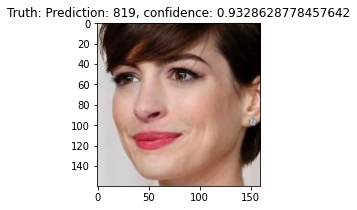

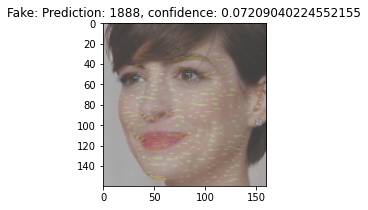

In [58]:
test_tensor = torch.tensor(transform.resize(np.array(Image.open('./31.jpg')), (160, 160)), device='cuda', dtype=torch.float).permute((2, 0, 1)).unsqueeze(0)
test_img = test_tensor.cpu().detach().numpy()

true_confs = F.softmax(attacked_model(test_tensor), -1).cpu().detach().numpy()[0]
fake_confs = F.softmax(attacked_model((test_tensor + generator_model(test_tensor)) / 2), -1).cpu().detach().numpy()[0]

plt.figure(figsize=(3,3))
true_image = test_img[0].transpose((1, 2, 0))
plt.imshow(true_image, cmap='gray')
plt.title("Truth: Prediction: {}, confidence: {}".format(np.argmax(true_confs), true_confs.max()))

plt.figure(figsize=(3,3))
false_image = ((test_img + generator_model(test_tensor).cpu().detach().numpy()) / 2)[0].transpose((1, 2, 0))
plt.imshow(false_image, cmap='gray')
plt.title("Fake: Prediction: {}, confidence: {}".format(np.argmax(fake_confs), fake_confs.max()))

In [59]:
Image.fromarray((true_image * 255).astype(np.uint8)).save('./true.jpg')
Image.fromarray((false_image * 255).astype(np.uint8)).save('./false.jpg')

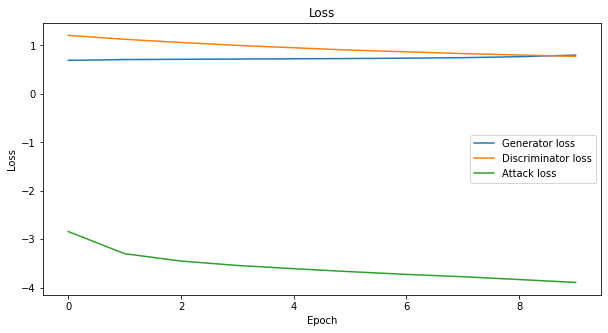

In [17]:
plt.figure(figsize=(10,5))
plt.title("Loss")
plt.plot(res[0],label="Generator loss")
plt.plot(res[1],label="Discriminator loss")
plt.plot(res[2],label="Attack loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()